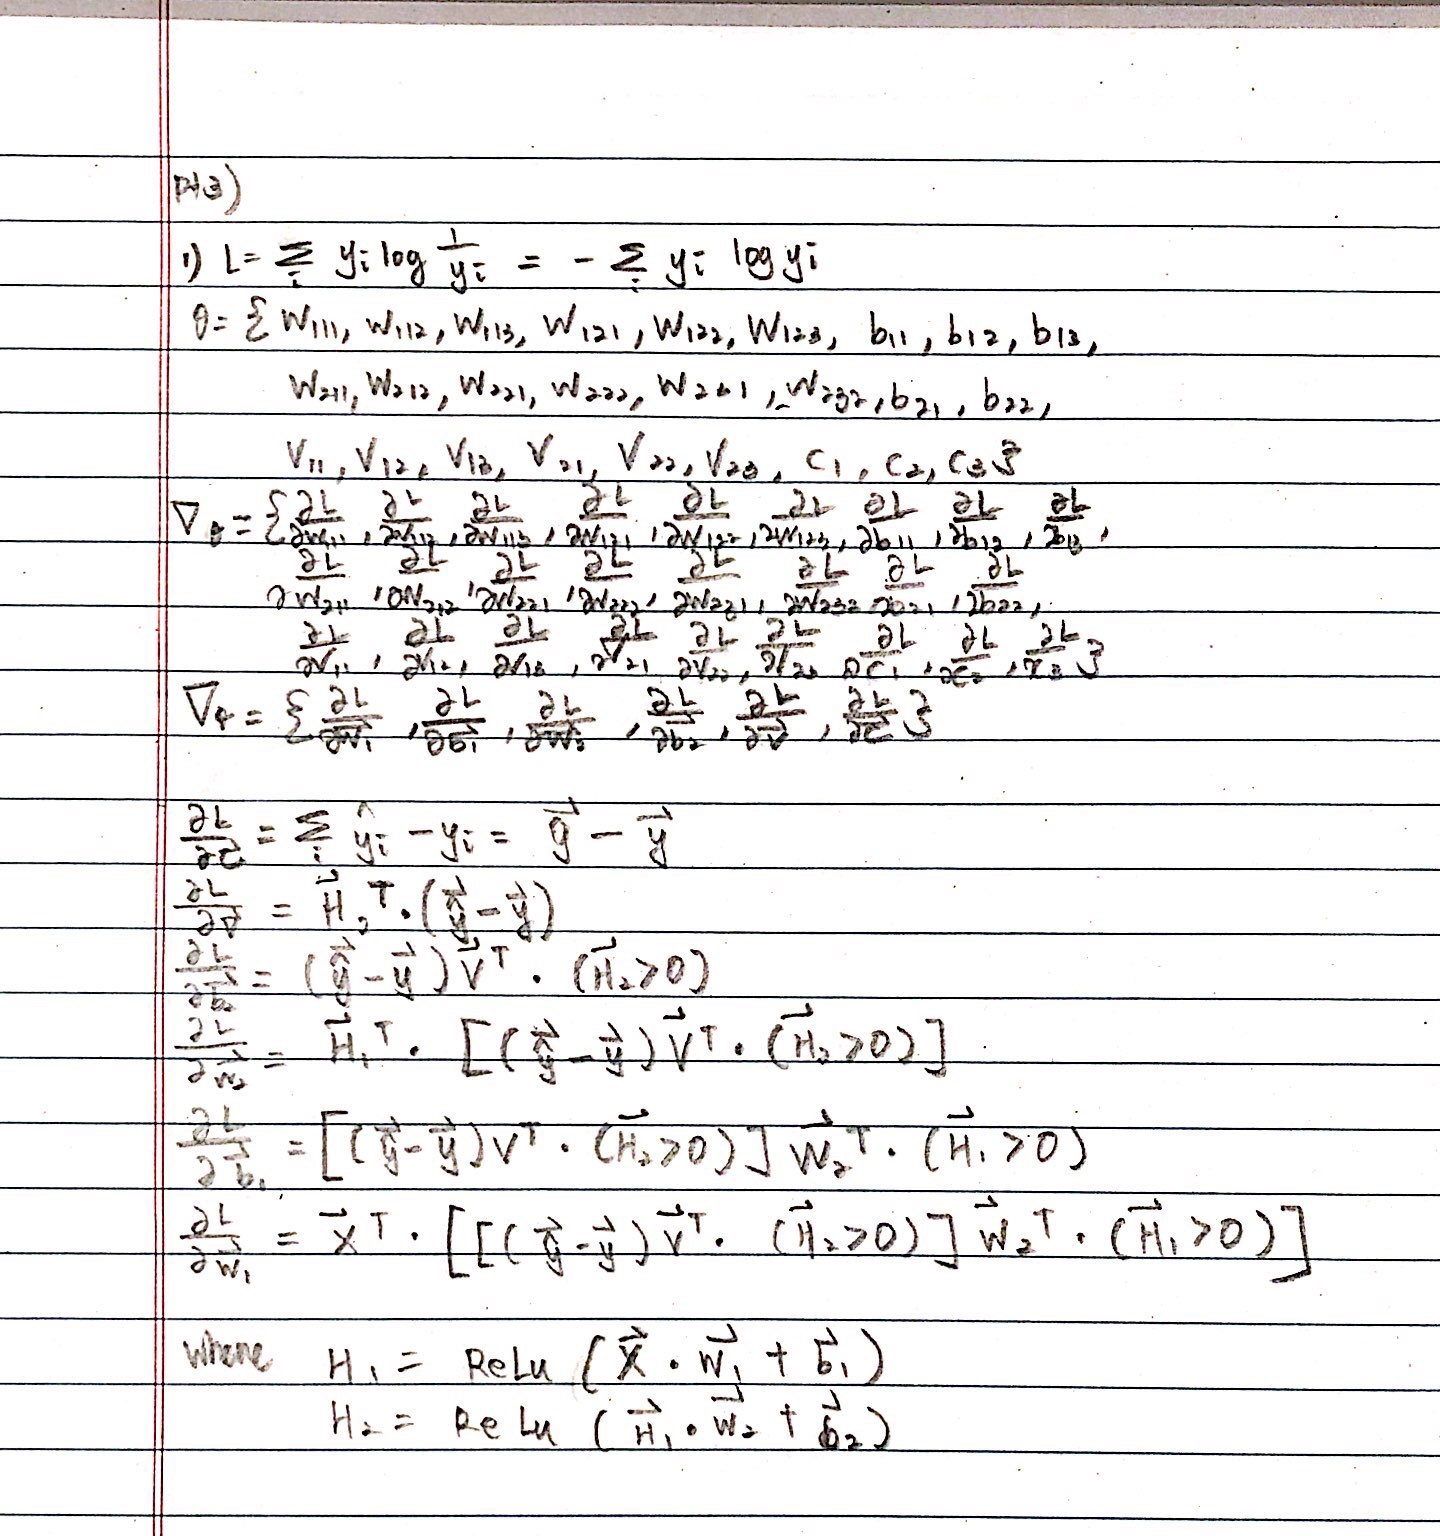

In [1]:
# modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# helper functions
def relu(x):
    return np.maximum(x,0)

def relu_derivative(x):
    return np.where(x>0, 1, 0)

def softmax(z):
    return np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

def loss(y, y_hat):
    # cross entropy
    tot = y * np.log(y_hat)
    return -tot.sum()

def yhat(x, W1, b1, W2, b2, V, c):
    # returns model prediction 
    H1 = relu(np.dot(x,W1) + b1)
    H2 = relu(np.dot(H1,W2) + b2)
    y_hat = softmax(np.dot(H2,V) + c)
    return y_hat

def forward(X,parameters):
    # Unpacking parameters    
    W1,b1,W2,b2,V,c = parameters
    # Forward pass
    a1 = X.dot(W1) + b1
    H1 = relu(a1)
    a2 = H1.dot(W2) + b2
    H2 = relu(a2)
    a3 = H2.dot(V) + c
    Y_hat = softmax(a3)
    return Y_hat

def pack_params(param_vec):
    w1_11, w1_12, w1_21, w1_22, w1_31, w1_32, b1_1, b1_2, b1_3, w2_11, w2_12, w2_13, w2_21, w2_22, w2_23, b2_1, b2_2, v_11, v_12, v_21, v_22, v_31, v_32, c_1, c_2, c_3 = param_vec
    W1 = np.array([[w1_11,w1_12],[w1_21,w1_22],[w1_31,w1_32]]).T
    b1 = np.array([b1_1, b1_2, b1_3])
    W2 = np.array([[w2_11,w2_12,w2_13],[w2_21,w2_22,w2_23]]).T
    b2 = np.array([b2_1, b2_2])
    V = np.array([[v_11, v_12],[v_21, v_22],[v_31, v_32]]).T
    c = np.array([c_1, c_2, c_3])
    return((W1, b1, W2, b2, V, c))
    
def unpack_params(W1,b1,W2,b2,V,c):
    W1, W2, V = W1.T, W2.T, V.T
    w1_11, w1_12, w1_21, w1_22, w1_31, w1_32 = W1[0,0], W1[0,1], W1[1,0], W1[1,1], W1[2,0], W1[2,1]
    b1_1, b1_2, b1_3 = b1[0], b1[1], b1[2]
    w2_11, w2_12, w2_13, w2_21, w2_22, w2_23 = W2[0,0], W2[0,1], W2[0,2], W2[1,0], W2[1,1], W2[1,2]
    b2_1, b2_2 = b2[0], b2[1]
    v_11, v_12, v_21, v_22, v_31, v_32 = V[0,0], V[0,1], V[1,0], V[1,1], V[2,0], V[2,1]
    c_1, c_2, c_3 = c[0], c[1], c[2]
    return np.array([w1_11, w1_12, w1_21, w1_22, w1_31, w1_32, b1_1, b1_2, b1_3,  w2_11, w2_12, w2_13, w2_21, w2_22, w2_23, b2_1, b2_2, v_11, v_12, v_21, v_22, v_31, v_32, c_1, c_2, c_3])

# 2. Write a function grad f(...) that takes in a weights vector and returns the gradient of the Loss at that location.
def grad_f(param_vec, x, y):
    W1, b1, W2, b2, V, c = pack_params(param_vec)
    
    a1 = x.dot(W1) + b1
    H1 = relu(a1)
    a2 = H1.dot(W2) + b2
    H2 = relu(a2)
    a3 = H2.dot(V) + c
    y_hat = softmax(a3)
    
    d_V_param = y_hat - y
    d_W2_param = d_V_param.dot(V.T) * (H2 > 0)
    d_W1_param = d_W2_param.dot(W2.T) * (H1 > 0)
    
    d_V = H2.T.dot(d_V_param)
    d_c = d_V_param.sum(axis=0)
    d_W2 = H1.T.dot(d_W2_param)
    d_b2 = (d_W2_param).sum(axis=0)
    d_W1 = x.T.dot(d_W1_param)
    d_b1 = (d_W1_param).sum(axis=0)
    
    param_vec = unpack_params(d_W1, d_b1, d_W2, d_b2, d_V, d_c)
    return np.array(param_vec)

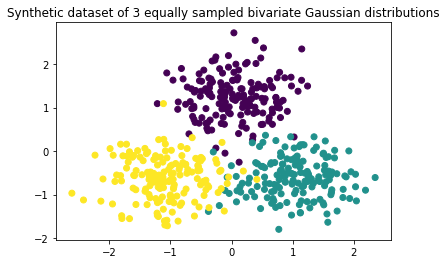

In [3]:
# 3. Generate a synthetic dataset of 3 equally sampled bivariate Gaussian distributions with parameters
# that you’ll use for fitting your network. Plot your sample dataset, coloring data points by their respective class.
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
            
        # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).as_matrix() 

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl

x,y,cl = gen_gmm_data(500)
plt.clf()
plt.scatter(x[:,0], x[:,1], c=cl[0])
plt.title("Synthetic dataset of 3 equally sampled bivariate Gaussian distributions")
plt.show()

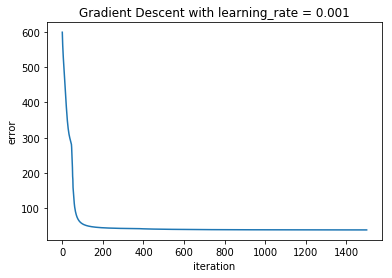

In [4]:
# 4. Fit your network using Gradient Descent. Keep track of the total Loss at each iteration and plot the result.
def grad_descent(x, y, iterations=10, learning_rate=1e-2):
    point = np.random.uniform(-1,1,size=26).astype("float128")
    trajectory = [point]
    losses = [loss(y, yhat(x, *pack_params(point)))]
    
    for i in range(iterations):
        grad = grad_f(point, x, y)
        point = point - learning_rate * grad
        trajectory.append(point)
        losses.append(loss(y, yhat(x, *pack_params(point))))
    return (np.array(trajectory), losses)

learning_rate = 1e-3
x,y,cl = gen_gmm_data(500)
traj, losses = grad_descent(x, y, iterations=1500,learning_rate=learning_rate)
plt.clf()
plt.plot(losses)
plt.title("Gradient Descent with learning_rate = {}".format(learning_rate))
plt.xlabel("iteration")
plt.ylabel("error")
plt.show()

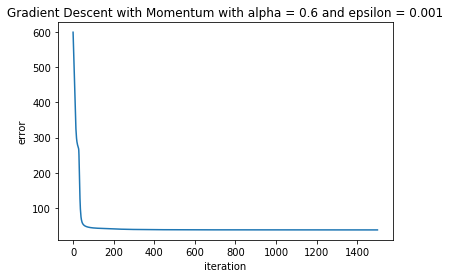

In [5]:
# 5. Repeat the exercise above using Momentum. Comment on whether your algorithm seems to converge more efficiently.
def grad_descent_momentum(x, y, iterations=10, alpha=.9, epsilon=10):
    point = np.random.uniform(-1,1,size=26).astype("float128")
    trajectory = [point]
    v = np.zeros(point.size)
    losses = [loss(y, yhat(x, *pack_params(point)))]
    
    for i in range(iterations):
        grad = grad_f(point, x, y)
        v = alpha*v + epsilon*grad
        point = point - v
        trajectory.append(point)
        losses.append(loss(y, yhat(x, *pack_params(point))))
    return (np.array(trajectory), losses)

alpha = 0.6
epsilon = 1e-3
x,y,cl = gen_gmm_data(500)
traj, losses = grad_descent_momentum(x, y, iterations=1500, alpha=alpha, epsilon=epsilon)
plt.clf()
plt.plot(losses)
plt.title("Gradient Descent with Momentum with alpha = {} and epsilon = {}".format(alpha, epsilon))
plt.xlabel("iteration")
plt.ylabel("error")
plt.show()

Gradient Descent (GD) function with Momentum seems to converge more efficiently than the function without Momentum.
As you can see from the two above graphs, the value of error drops quicker and gets flatten ealier between iteration = 0 to 200 on the graph of GD with Momentum compared to the GD without Momentum.